<a href="https://colab.research.google.com/github/Jeongchan-Kim/Drug-Toxicity-Prediction-Classification-ver-/blob/main/Drug_Toxicity_Prediction_(Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyTDC
!pip install lifelines
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Preparing Data**

In [ ]:
from tdc.single_pred import Tox

# Upload LD50 data using TDC api
data = Tox(name = 'LD50_Zhu')
# Divide train-valid-test data
split = data.get_split()

Downloading...
100%|██████████| 707k/707k [00:00<00:00, 6.37MiB/s]
Loading...
Done!


In [ ]:
# checking divided data
split.keys()

dict_keys(['train', 'valid', 'test'])

# **Data pre-processing**

Molecular representations in AI-driven drug discovery: a review and practical guide

In [ ]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np

def smiles2morgan(s, radius = 2, nBits = 1024):
    """
    SMILES data -> morgan fingerprint (vetot of 1024 bits)

    Args:
        s (str): SMILES of a drug
        radius (int): ECFP radius
        bBits (int): size of binary representation

    Return ():
        morgan fingerprint 
    """
    try:
        mol = Chem.MolFromSmiles(s)
        features_vec = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        features = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(features_vec, features)
    except:
        print('rdkit not found this smiles for morgan: ' + s + ' convert to all 0 features')
        features = np.zeros((nBits, ))
        
    return features

In [ ]:
# adapting pre-prdcessing function
for mode in ['train', 'valid', 'test']:  
  # add columns
  split[mode]['embedding'] = split[mode]['Drug'].apply(smiles2morgan)
  split[mode]['Y_binary'] = split[mode]['Y'].apply(lambda x: int(x < 2))

In [ ]:
split["test"]

,Drug_ID,Drug,Y,embedding,Y_binary
0,"Ether, alpha-(bromomethyl)-p-cyclopentylbenzyl...",CCCCOC(CBr)c1ccc(C2CCCC2)cc1,3.114,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"Benzene, 1,4-dinitroso-",O=Nc1ccc(N=O)cc1,2.125,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"Succinic acid, mercapto-, diethyl ester, S-est...",CCOC(=O)CC(SP(=O)(OC)SC)C(=O)OCC,3.466,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"Phosphorodithioic acid, O,S,S-triethyl ester",CCOP(=O)(SCC)SCC,3.185,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"Phenol, 2-octyl- (9CI)",CCCCCCCCc1ccccc1O,1.867,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
...,...,...,...,...,...
1472,"1H-1,2,4-Triazole, 1-((2-(2,4-dichlorophenyl)-...",CCCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1,2.353,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1473,"Phosphorothioic acid, O-(3-chloro-4-nitropheny...",CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])c(Cl)c1,3.814,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1474,"Dibenz(b,f)oxepin-2-acetic acid, 10,11-dihydro...",Cc1ccc2c(c1)CC(=O)c1cc(CC(=O)O)ccc1O2,2.937,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1475,"Phosphorothioic acid, O,O-dimethyl S-(2-(ethyl...",CCS(=O)(=O)CCSP(=O)(OC)OC,3.908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


# **Torch Dataset & Data Loader for batch**

In [ ]:
import torch
from torch import nn 
import torch.nn.functional as F
from torch.utils import data

In [ ]:
class data_process_loader(data.Dataset):

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        v_d = self.df.iloc[index]['embedding']  # input
        y = self.df.iloc[index]['Y_binary'] # label

        return v_d, y

In [ ]:
train_dataset = data_process_loader(split["train"])
valid_dataset = data_process_loader(split["valid"])
test_dataset = data_process_loader(split["test"])

In [ ]:
# hyperparameter for Data Loader
params = {'batch_size': 64,
        'shuffle': True,
        'num_workers': 1,
        'drop_last': False}

In [ ]:
train_loader = data.DataLoader(train_dataset, **params)
valid_loader = data.DataLoader(valid_dataset, **params)
test_loader = data.DataLoader(test_dataset, **params)

In [ ]:
for v_d, y in train_loader:
    print(v_d)
    print(v_d.shape)
    print()
    print(y)
    print(y.shape)
    break

tensor([[0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)
torch.Size([64, 1024])

tensor([1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0])
torch.Size([64])


# **MODEL**

# **Feature Extractor**

In [ ]:
class MLP(nn.Sequential):
	def __init__(self, input_dim, output_dim, hidden_dims_lst):

		super(MLP, self).__init__()
  
		# Feature extractor layer size 
		layer_size = len(hidden_dims_lst) + 1

		# dropout
		self.dropout = nn.Dropout(0.3)

		dims = [input_dim] + hidden_dims_lst + [output_dim]

		# linear layer
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

	def forward(self, v):
		v = v.float().to(device)
		for i, l in enumerate(self.predictor):
			v = F.relu(self.dropout(l(v)))
		return v  

# **Classifier**

In [ ]:
class Classifier(nn.Sequential):
	def __init__(self, model_drug, hidden_dim_drug, cls_hidden_dims):
		
		super(Classifier, self).__init__()
  
		# feature extractor
		self.model_drug = model_drug

		# dropout
		self.dropout = nn.Dropout(0.3)
  
		# classifier input dim
		self.input_dim_drug = hidden_dim_drug

		# classifier hidden dim
		self.hidden_dims = cls_hidden_dims

		# classifier layer size including output layer
		layer_size = len(self.hidden_dims) + 1

		# list that has each size of dim every layer
		dims = [self.input_dim_drug] + self.hidden_dims + [2]
		
		# linear layer
		self.predictor = nn.ModuleList([nn.Linear(dims[i], dims[i+1]) for i in range(layer_size)])

	def forward(self, v_D):
		# encoding input data of feature extractor
		v_f = self.model_drug(v_D)
		
		# forword-pass with classify 
		for i, l in enumerate(self.predictor):
			if i==(len(self.predictor)-1):
				v_f = l(v_f)
			else:
				v_f = F.relu(self.dropout(l(v_f)))
		return v_f 

In [ ]:
# model hyperparameter
input_dim_drug = 1024
hidden_dim_drug = 256
cls_hidden_dims = [512]
mlp_hidden_dims_drug = [1024]

In [ ]:
model_drug = MLP(1024, hidden_dim_drug, mlp_hidden_dims_drug)

In [ ]:
model_drug

MLP(
  (dropout): Dropout(p=0.3, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=256, bias=True)
  )
)

# **MODEL Training**

In [ ]:
# hyperparameter for model training
learning_rate = 0.0001
decay         = 0.00001
train_epoch   = 50

In [ ]:
# optimizer 
opt = torch.optim.Adam(model_drug.parameters(), lr = learning_rate, weight_decay = decay)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current Device: {device}")

Current Device: cuda


In [ ]:
import copy
from prettytable import PrettyTable
from time import time
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

In [ ]:
loss_history_train = []
loss_history_val = []

min_acc = 0

# 모델 GPU 메모리에 올리기
model_drug = model_drug.to(device)

# Best 모델 초기화
model_best = copy.deepcopy(model_drug)

# 결과 정리를 위한 PrettyTable
valid_metric_record = []
valid_metric_header = ["# epoch"] 
valid_metric_header.extend(["Accuracy", "sensitivity", "specificity", "roc_score"])
table = PrettyTable(valid_metric_header)

float2str = lambda x:'%0.4f'%x # float 소숫점 4자리까지만 str로 바꾸기 

# 학습 진행
print('--- Go for Training ---')
# 학습 시작 시간 기록 
t_start = time() 

for epo in range(train_epoch):
    # Model training 
    model_drug.train()
    
    # Mini-batch 학습 
    for i, (v_d, label) in enumerate(train_loader):
        # input data gpu에 올리기 
        v_d = v_d.float().to(device) 
        # forward-pass
        output = model_drug(v_d)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록 
        loss_history_train.append(loss.item())

        # gradient 초기화
        opt.zero_grad()
        # back propagation
        loss.backward()
        # parameter update
        opt.step()
    
    # gradient tracking X
    with torch.set_grad_enabled(False):
        
        y_pred = []
        y_score = []
        y_label = []
        # model_drug validation
        model_drug.eval()

        for i, (v_d, label) in enumerate(valid_loader):
            # input data gpu에 올리기 
            v_d = v_d.float().to(device) 
            # forward-pass
            output = model_drug(v_d)

            # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
            loss = loss_fn(output, label.to(device))

            # 각 iteration 마다 loss 기록 
            loss_history_val.append(loss.item())

            pred = output.argmax(dim=1, keepdim=True)
            score = nn.Softmax(dim = 1)(output)[:,1]

            # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
            pred = pred.cpu().numpy()
            score = score.cpu().numpy()
            label = label.cpu().numpy()

            # 예측값, 참값 기록하기
            y_label = y_label + label.flatten().tolist()
            y_pred = y_pred + pred.flatten().tolist()
            y_score = y_score + score.flatten().tolist()
    
    # metric 계산
    classification_metrics = classification_report(y_label, y_pred,
                        target_names = ['NonToxic', 'Toxic'],
                        output_dict= True)
    
    # sensitivity is the recall of the positive class
    sensitivity = classification_metrics['Toxic']['recall']
    # specificity is the recall of the negative class 
    specificity = classification_metrics['NonToxic']['recall']
    # accuracy
    accuracy = classification_metrics['accuracy']
    # confusion matrix
    conf_matrix = confusion_matrix(y_label, y_pred)
    # roc score
    roc_score = roc_auc_score(y_label, y_score)


    # 계산한 metric 합치기
    lst = ["epoch " + str(epo)] + list(map(float2str,[accuracy, sensitivity, specificity, roc_score]))

    # 각 epoch 마다 결과값 pretty table에 기록
    table.add_row(lst)
    valid_metric_record.append(lst)
    
    # mse 기준으로 best model 업데이트
    if accuracy > min_acc:
        # best model deepcopy 
        model_best = copy.deepcopy(model_drug)
        # max MSE 업데이트 
        min_acc = accuracy

    # 각 epoch 마다 결과 출력 
    print('Validation at Epoch '+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
						 + str(sensitivity)[:7] + ', specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])

--- Go for Training ---
Validation at Epoch 1 , Accuracy: 0.70325 , sensitivity: 0.0, specificity: 1.0 , roc_score: 0.37340
Validation at Epoch 2 , Accuracy: 0.70325 , sensitivity: 0.0, specificity: 1.0 , roc_score: 0.42688
Validation at Epoch 3 , Accuracy: 0.74254 , sensitivity: 0.17351, specificity: 0.9826589595375722 , roc_score: 0.54846
Validation at Epoch 4 , Accuracy: 0.76693 , sensitivity: 0.31506, specificity: 0.9576107899807321 , roc_score: 0.64212
Validation at Epoch 5 , Accuracy: 0.78997 , sensitivity: 0.40639, specificity: 0.9518304431599229 , roc_score: 0.70234
Validation at Epoch 6 , Accuracy: 0.78997 , sensitivity: 0.49771, specificity: 0.9132947976878613 , roc_score: 0.73198
Validation at Epoch 7 , Accuracy: 0.80352 , sensitivity: 0.55251, specificity: 0.9094412331406551 , roc_score: 0.75724
Validation at Epoch 8 , Accuracy: 0.80758 , sensitivity: 0.56164, specificity: 0.9113680154142582 , roc_score: 0.78108
Validation at Epoch 9 , Accuracy: 0.80758 , sensitivity: 0.579

# **Model Testing**

In [ ]:
model = model_best

y_pred = []
y_label = []
y_score = []

model.eval()
for i, (v_d, label) in enumerate(valid_loader):
    # input data gpu에 올리기 
    v_d = v_d.float().to(device) 

    with torch.set_grad_enabled(False):
        # forward-pass
        output = model(v_d)

        # 미리 정의한 손실함수(MSE)로 손실(loss) 계산 
        loss = loss_fn(output, label.to(device))

        # 각 iteration 마다 loss 기록 
        loss_history_val.append(loss.item())

        pred = output.argmax(dim=1, keepdim=True)
        score = nn.Softmax(dim = 1)(output)[:,1]

        # 예측값, 참값 cpu로 옮기고 numpy 형으로 변환
        pred = pred.cpu().numpy()
        score = score.cpu().numpy()
        label = label.cpu().numpy()

    # 예측값, 참값 기록하기
    y_label = y_label + label.flatten().tolist()
    y_pred = y_pred + pred.flatten().tolist()
    y_score = y_score + score.flatten().tolist()

# metric 계산
classification_metrics = classification_report(y_label, y_pred,
                    target_names = ['NonToxic', 'Toxic'],
                    output_dict= True)
# sensitivity is the recall of the positive class
sensitivity = classification_metrics['Toxic']['recall']
# specificity is the recall of the negative class 
specificity = classification_metrics['NonToxic']['recall']
# accuracy
accuracy = classification_metrics['accuracy']
# confusion matrix
conf_matrix = confusion_matrix(y_label, y_pred)
# roc score
roc_score = roc_auc_score(y_label, y_score)

# 각 epoch 마다 결과 출력 
print('TestSet Performance Metric'+ str(epo + 1) + ' , Accuracy: ' + str(accuracy)[:7] + ' , sensitivity: '\
                        + str(sensitivity)[:7] + ' specificity: ' + str(f"{specificity}") +' , roc_score: '+str(roc_score)[:7])

TestSet Performance Metric50 , Accuracy: 0.81436 , sensitivity: 0.67123 specificity: 0.8747591522157996 , roc_score: 0.85410


In [ ]:
import matplotlib.pyplot as plt

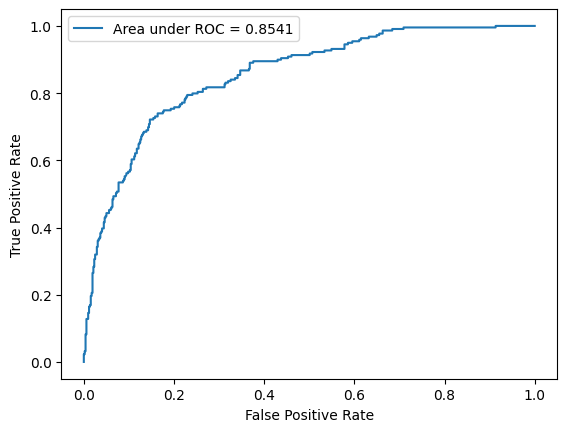

In [ ]:
# plot the roc curve    
fpr, tpr, _ = roc_curve(y_label, y_score)
plt.plot(fpr, tpr, label = "Area under ROC = {:.4f}".format(roc_score))
plt.legend(loc = 'best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

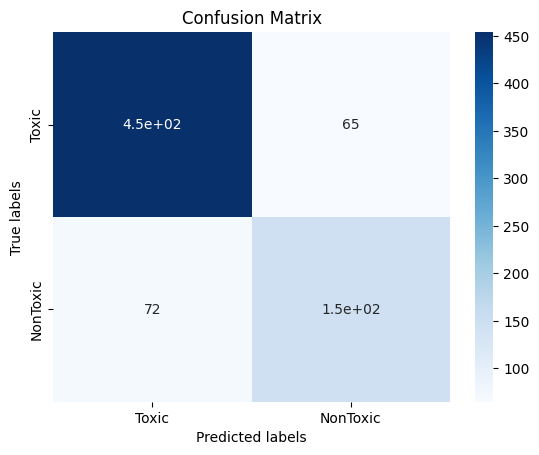

In [ ]:
import seaborn as sns

conf_matrix = conf_matrix
ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, cmap = 'Blues'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Toxic', 'NonToxic']); ax.yaxis.set_ticklabels(['Toxic', 'NonToxic']);